# Drug Consumption: Testes com Classificadores

In [1]:
import pandas as pd
import numpy as np
import utils as ut
from pprint import pprint

from importlib import reload
reload(ut)

/home/ngmonteiro/miniconda3/envs/py/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


<module 'utils' from '/home/ngmonteiro/llm_experiments/ufes/2024-1-P1-Drug-Consumption/utils.py'>

In [2]:
data = pd.read_csv('data/drug_consumption_preprocessed.csv', index_col="ID")
pd.set_option('display.max_columns', None)

# Análises

## Características Normalizadas
São criados métodos que serão utilizados posteriormente para auxiliar na organização. Código encontrado em "utils.py"

```python
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

numCols = [
    "Neuroticism",
    "Extraversion",
    "Openness",
    "Agreeableness",
    "Conscientiousness",
    "Impulsiveness",
    "Sensationness",
]


def metric_preprocessor():
    return ColumnTransformer(
        [("numerical", StandardScaler(), numCols)],
        verbose_feature_names_out=False,
        remainder="passthrough",
    )
```

## Análise de Substâncias
No dataset são descritas 18 tipos de substâncias lícitas e ilícitas, além de uma substância que é fictícia. Tal inserção é justificada pelo fato que o dataset leva em consideração que alguns dos indivíduos podem ser "over-claimers", ou seja, podem não ser fontes de informação tão confiáveis.

Dessa forma, temos duas opções:
- Remover os dados que podem ser exagerados ou
- Deixar os dados, já que são mínimos e podem não afetar o modelo.

Aqui, dividiremos o dataset em duas versões. A substância fictícia será removida de ambos.

In [3]:
print(data["Semer"].value_counts())

# Versão sem os indivíduos menos confiáveis.
data_filtered = data[data["Semer"] == 0]

0    1877
2       3
3       2
1       2
4       1
Name: Semer, dtype: int64


## Análise de Características
Podemos tentar analisar o quão essenciais algumas características podem ser em relação à variação dos dados. Dessa forma, podemos selecionar um subconjunto que possa classificar e generalizar melhor os modelos.

In [6]:
# Ignorando o país de residência + nominais + droga fictícia + etnia.
ignore_cols = ["Country", "Age_", "Education_", "Semer", "Semer_", "Ethnicity"] + [
    x + "_" for x in ut.drugs
]
data_ = data_filtered.drop(columns=ut.drugs).drop(columns=ignore_cols)

In [7]:
from sklearn.feature_selection import SelectKBest

feature_df = pd.DataFrame(index=ut.drugs, columns=data_.columns)
for d in ut.drugs:
    selector = SelectKBest(k="all").fit(data_, data_filtered[d])
    for x, y in zip(selector.scores_, selector.feature_names_in_):
        feature_df.loc[d, y] = x
        
feature_df.mean().sort_values(ascending=False)

Age                  42.725943
Sensationness        34.112773
Openness             21.036624
Impulsiveness        17.246514
Gender               14.766595
Conscientiousness    12.716263
Education             8.001154
Agreeableness         6.210867
Neuroticism           6.144711
Extraversion          3.144072
dtype: float64

Vemos que há certo peso em características como idade, gênero e escolaridade, mas as métricas de personalidade também são muito efetivas. Posteriormente, serão feitas novas análises levando em conta a correlação entre características.

# Experimentos

## Teste com LazyPredict
Aqui realizamos o teste de classificadores com LazyClassifier para todas as substâncias. Dessa forma, podemos observar os classificadores que mais frequentemente retornam os maiores valores.

Para facilitar o trabalho dos classificadores, estamos considerando o problema como binário:
- 1 para indivíduos que tiveram contato com a substância pelo menos que t.
- 0 para indivíduos que não tiveram contato em um tempo maior que t.

Em que t pode ser tanto ano, mês ou semana de acordo com o teste sendo feito.

Com isso, podemos analisar casos mais recorrentes ao invés de focar em casos excepcionais, como casos isolados em tempos muito curtos, o que podem prejudicar a classificação de usuários com uso mais constante.

### Definições de Funções

In [23]:
from lazypredict.Supervised import LazyClassifier
from sklearn.model_selection import StratifiedKFold


def run_classifiers(time_threshold=3):
    all_results = {}

    for d in ut.drugs:
        # Não precisamos de contabilizar a classificação de drogas mais gerais/fictícias.
        if d in ut.lesser_drugs:
            continue

        all_results[d] = []

        # Labels são transformados em binário com um threshold.
        labels = np.where(data_filtered[d] > time_threshold, 1, 0)

        n_splits = 4
        cv = StratifiedKFold(n_splits=n_splits)
        classif_avg = {}
        
        for train, test in cv.split(data_, labels):
            # Normalizando as características de métricas de personalidade
            preprocessor = ut.metric_preprocessor()
            train_scaled = preprocessor.fit_transform(data_.iloc[train])
            test_scaled = preprocessor.transform(data_.iloc[test])

            clf = LazyClassifier()
            models, _ = clf.fit(train_scaled, test_scaled, labels[train], labels[test])

            for c, s in models.iterrows():
                classif_avg[c] = classif_avg.get(c, 0) + s["Balanced Accuracy"] / n_splits

        all_results[d] = classif_avg

    return all_results

### Testando com diferentes thresholds de tempo
Testamos os vários classificadores com diferentes variações do threshold de tempo que determina se consideramos o uso constante ou não.

In [27]:
threshold_results = {}

for t in [2, 3, 4]:
    results = run_classifiers(t)

    classifiers = {}
    for k, i in results.items():
        for c, s in i.items():
            classifiers[c] = classifiers.get(c, 0) + s

    all_models_sorted = sorted(classifiers.items(), key=lambda item: -item[1])

    k = 7
    threshold_results[t] = all_models_sorted[:k]

100%|██████████| 29/29 [00:00<00:00, 30.58it/s]


[LightGBM] [Info] Number of positive: 324, number of negative: 1083
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000074 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 237
[LightGBM] [Info] Number of data points in the train set: 1407, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.230277 -> initscore=-1.206747
[LightGBM] [Info] Start training from score -1.206747


100%|██████████| 29/29 [00:00<00:00, 30.14it/s]


[LightGBM] [Info] Number of positive: 325, number of negative: 1083
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000074 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 240
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.230824 -> initscore=-1.203665
[LightGBM] [Info] Start training from score -1.203665


100%|██████████| 29/29 [00:00<00:00, 30.76it/s]


[LightGBM] [Info] Number of positive: 325, number of negative: 1083
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000079 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 236
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.230824 -> initscore=-1.203665
[LightGBM] [Info] Start training from score -1.203665


100%|██████████| 29/29 [00:00<00:00, 29.94it/s]


[LightGBM] [Info] Number of positive: 325, number of negative: 1083
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000077 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 236
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.230824 -> initscore=-1.203665
[LightGBM] [Info] Start training from score -1.203665


100%|██████████| 29/29 [00:00<00:00, 32.72it/s]


[LightGBM] [Info] Number of positive: 99, number of negative: 1308
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000072 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 236
[LightGBM] [Info] Number of data points in the train set: 1407, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.070362 -> initscore=-2.581135
[LightGBM] [Info] Start training from score -2.581135


100%|██████████| 29/29 [00:00<00:00, 32.63it/s]


[LightGBM] [Info] Number of positive: 99, number of negative: 1309
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000070 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 239
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.070312 -> initscore=-2.581899
[LightGBM] [Info] Start training from score -2.581899


100%|██████████| 29/29 [00:00<00:00, 33.51it/s]


[LightGBM] [Info] Number of positive: 99, number of negative: 1309
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000077 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 236
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.070312 -> initscore=-2.581899
[LightGBM] [Info] Start training from score -2.581899


100%|██████████| 29/29 [00:00<00:00, 33.24it/s]


[LightGBM] [Info] Number of positive: 99, number of negative: 1309
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000072 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 236
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.070312 -> initscore=-2.581899
[LightGBM] [Info] Start training from score -2.581899


100%|██████████| 29/29 [00:01<00:00, 25.86it/s]


[LightGBM] [Info] Number of positive: 399, number of negative: 1008
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000076 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 236
[LightGBM] [Info] Number of data points in the train set: 1407, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.283582 -> initscore=-0.926762
[LightGBM] [Info] Start training from score -0.926762


100%|██████████| 29/29 [00:01<00:00, 26.38it/s]


[LightGBM] [Info] Number of positive: 399, number of negative: 1009
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000072 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 239
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.283381 -> initscore=-0.927754
[LightGBM] [Info] Start training from score -0.927754


100%|██████████| 29/29 [00:01<00:00, 28.21it/s]


[LightGBM] [Info] Number of positive: 399, number of negative: 1009
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000072 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 236
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.283381 -> initscore=-0.927754
[LightGBM] [Info] Start training from score -0.927754


100%|██████████| 29/29 [00:01<00:00, 28.47it/s]


[LightGBM] [Info] Number of positive: 399, number of negative: 1009
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000071 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 236
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.283381 -> initscore=-0.927754
[LightGBM] [Info] Start training from score -0.927754


100%|██████████| 29/29 [00:00<00:00, 29.39it/s]


[LightGBM] [Info] Number of positive: 743, number of negative: 664
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000074 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 237
[LightGBM] [Info] Number of data points in the train set: 1407, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.528074 -> initscore=0.112414
[LightGBM] [Info] Start training from score 0.112414


100%|██████████| 29/29 [00:01<00:00, 28.42it/s]


[LightGBM] [Info] Number of positive: 744, number of negative: 664
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000076 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 239
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.528409 -> initscore=0.113759
[LightGBM] [Info] Start training from score 0.113759


100%|██████████| 29/29 [00:00<00:00, 29.05it/s]


[LightGBM] [Info] Number of positive: 743, number of negative: 665
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000075 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 236
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.527699 -> initscore=0.110909
[LightGBM] [Info] Start training from score 0.110909


100%|██████████| 29/29 [00:00<00:00, 29.13it/s]


[LightGBM] [Info] Number of positive: 743, number of negative: 665
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000076 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 236
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.527699 -> initscore=0.110909
[LightGBM] [Info] Start training from score 0.110909


100%|██████████| 29/29 [00:00<00:00, 30.40it/s]


[LightGBM] [Info] Number of positive: 310, number of negative: 1097
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000077 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 237
[LightGBM] [Info] Number of data points in the train set: 1407, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220327 -> initscore=-1.263762
[LightGBM] [Info] Start training from score -1.263762


100%|██████████| 29/29 [00:00<00:00, 30.30it/s]


[LightGBM] [Info] Number of positive: 311, number of negative: 1097
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000074 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 239
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220881 -> initscore=-1.260542
[LightGBM] [Info] Start training from score -1.260542


100%|██████████| 29/29 [00:00<00:00, 29.71it/s]


[LightGBM] [Info] Number of positive: 311, number of negative: 1097
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000068 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 236
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220881 -> initscore=-1.260542
[LightGBM] [Info] Start training from score -1.260542


100%|██████████| 29/29 [00:00<00:00, 30.16it/s]


[LightGBM] [Info] Number of positive: 310, number of negative: 1098
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000073 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 236
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220170 -> initscore=-1.264673
[LightGBM] [Info] Start training from score -1.264673


100%|██████████| 29/29 [00:00<00:00, 35.13it/s]


[LightGBM] [Info] Number of positive: 59, number of negative: 1348
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000074 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 236
[LightGBM] [Info] Number of data points in the train set: 1407, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.041933 -> initscore=-3.128840
[LightGBM] [Info] Start training from score -3.128840


100%|██████████| 29/29 [00:00<00:00, 33.60it/s]


[LightGBM] [Info] Number of positive: 60, number of negative: 1348
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000072 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 239
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.042614 -> initscore=-3.112033
[LightGBM] [Info] Start training from score -3.112033


100%|██████████| 29/29 [00:00<00:00, 33.43it/s]


[LightGBM] [Info] Number of positive: 59, number of negative: 1349
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000080 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 236
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.041903 -> initscore=-3.129581
[LightGBM] [Info] Start training from score -3.129581
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


100%|██████████| 29/29 [00:00<00:00, 32.17it/s]


[LightGBM] [Info] Number of positive: 59, number of negative: 1349
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000072 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 236
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.041903 -> initscore=-3.129581
[LightGBM] [Info] Start training from score -3.129581


100%|██████████| 29/29 [00:01<00:00, 28.81it/s]


[LightGBM] [Info] Number of positive: 384, number of negative: 1023
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000073 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 237
[LightGBM] [Info] Number of data points in the train set: 1407, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.272921 -> initscore=-0.979852
[LightGBM] [Info] Start training from score -0.979852


100%|██████████| 29/29 [00:01<00:00, 28.11it/s]


[LightGBM] [Info] Number of positive: 385, number of negative: 1023
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000072 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 240
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.273438 -> initscore=-0.977251
[LightGBM] [Info] Start training from score -0.977251


100%|██████████| 29/29 [00:01<00:00, 28.62it/s]


[LightGBM] [Info] Number of positive: 385, number of negative: 1023
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000074 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 235
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.273438 -> initscore=-0.977251
[LightGBM] [Info] Start training from score -0.977251


100%|██████████| 29/29 [00:01<00:00, 27.98it/s]


[LightGBM] [Info] Number of positive: 385, number of negative: 1023
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000093 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 236
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.273438 -> initscore=-0.977251
[LightGBM] [Info] Start training from score -0.977251


100%|██████████| 29/29 [00:00<00:00, 33.09it/s]


[LightGBM] [Info] Number of positive: 88, number of negative: 1319
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000081 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 236
[LightGBM] [Info] Number of data points in the train set: 1407, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.062544 -> initscore=-2.707292
[LightGBM] [Info] Start training from score -2.707292


100%|██████████| 29/29 [00:00<00:00, 32.88it/s]


[LightGBM] [Info] Number of positive: 89, number of negative: 1319
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000099 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 239
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.063210 -> initscore=-2.695993
[LightGBM] [Info] Start training from score -2.695993


100%|██████████| 29/29 [00:00<00:00, 32.89it/s]


[LightGBM] [Info] Number of positive: 89, number of negative: 1319
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000076 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 236
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.063210 -> initscore=-2.695993
[LightGBM] [Info] Start training from score -2.695993


100%|██████████| 29/29 [00:00<00:00, 32.58it/s]


[LightGBM] [Info] Number of positive: 88, number of negative: 1320
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000080 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 236
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.062500 -> initscore=-2.708050
[LightGBM] [Info] Start training from score -2.708050
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


100%|██████████| 29/29 [00:00<00:00, 30.93it/s]


[LightGBM] [Info] Number of positive: 154, number of negative: 1253
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000075 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 237
[LightGBM] [Info] Number of data points in the train set: 1407, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.109453 -> initscore=-2.096343
[LightGBM] [Info] Start training from score -2.096343


100%|██████████| 29/29 [00:00<00:00, 30.26it/s]


[LightGBM] [Info] Number of positive: 155, number of negative: 1253
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000074 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 239
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.110085 -> initscore=-2.089871
[LightGBM] [Info] Start training from score -2.089871


100%|██████████| 29/29 [00:00<00:00, 32.02it/s]


[LightGBM] [Info] Number of positive: 155, number of negative: 1253
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000079 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 236
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.110085 -> initscore=-2.089871
[LightGBM] [Info] Start training from score -2.089871


100%|██████████| 29/29 [00:00<00:00, 32.16it/s]


[LightGBM] [Info] Number of positive: 154, number of negative: 1254
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000082 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 236
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.109375 -> initscore=-2.097141
[LightGBM] [Info] Start training from score -2.097141


100%|██████████| 29/29 [00:01<00:00, 27.38it/s]


[LightGBM] [Info] Number of positive: 420, number of negative: 987
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000075 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 237
[LightGBM] [Info] Number of data points in the train set: 1407, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.298507 -> initscore=-0.854415
[LightGBM] [Info] Start training from score -0.854415


100%|██████████| 29/29 [00:01<00:00, 28.30it/s]


[LightGBM] [Info] Number of positive: 421, number of negative: 987
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000076 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 239
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.299006 -> initscore=-0.852037
[LightGBM] [Info] Start training from score -0.852037


100%|██████████| 29/29 [00:00<00:00, 29.10it/s]


[LightGBM] [Info] Number of positive: 421, number of negative: 987
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000076 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 236
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.299006 -> initscore=-0.852037
[LightGBM] [Info] Start training from score -0.852037


100%|██████████| 29/29 [00:01<00:00, 26.62it/s]


[LightGBM] [Info] Number of positive: 421, number of negative: 987
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000080 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 236
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.299006 -> initscore=-0.852037
[LightGBM] [Info] Start training from score -0.852037


100%|██████████| 29/29 [00:00<00:00, 31.00it/s]


[LightGBM] [Info] Number of positive: 282, number of negative: 1125
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000078 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 237
[LightGBM] [Info] Number of data points in the train set: 1407, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200426 -> initscore=-1.383631
[LightGBM] [Info] Start training from score -1.383631


100%|██████████| 29/29 [00:00<00:00, 31.53it/s]


[LightGBM] [Info] Number of positive: 282, number of negative: 1126
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000078 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 241
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200284 -> initscore=-1.384520
[LightGBM] [Info] Start training from score -1.384520


100%|██████████| 29/29 [00:00<00:00, 31.38it/s]


[LightGBM] [Info] Number of positive: 282, number of negative: 1126
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000074 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 236
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200284 -> initscore=-1.384520
[LightGBM] [Info] Start training from score -1.384520


100%|██████████| 29/29 [00:00<00:00, 30.67it/s]


[LightGBM] [Info] Number of positive: 282, number of negative: 1126
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000075 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 235
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200284 -> initscore=-1.384520
[LightGBM] [Info] Start training from score -1.384520


100%|██████████| 29/29 [00:00<00:00, 30.06it/s]


[LightGBM] [Info] Number of positive: 239, number of negative: 1168
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000073 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 236
[LightGBM] [Info] Number of data points in the train set: 1407, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.169865 -> initscore=-1.586585
[LightGBM] [Info] Start training from score -1.586585


100%|██████████| 29/29 [00:00<00:00, 31.43it/s]


[LightGBM] [Info] Number of positive: 240, number of negative: 1168
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000081 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 239
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.170455 -> initscore=-1.582409
[LightGBM] [Info] Start training from score -1.582409


100%|██████████| 29/29 [00:00<00:00, 30.94it/s]


[LightGBM] [Info] Number of positive: 239, number of negative: 1169
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000076 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 236
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.169744 -> initscore=-1.587440
[LightGBM] [Info] Start training from score -1.587440


100%|██████████| 29/29 [00:00<00:00, 30.28it/s]


[LightGBM] [Info] Number of positive: 239, number of negative: 1169
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000079 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 236
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.169744 -> initscore=-1.587440
[LightGBM] [Info] Start training from score -1.587440


100%|██████████| 29/29 [00:00<00:00, 30.31it/s]


[LightGBM] [Info] Number of positive: 321, number of negative: 1086
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000074 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 237
[LightGBM] [Info] Number of data points in the train set: 1407, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.228145 -> initscore=-1.218815
[LightGBM] [Info] Start training from score -1.218815


100%|██████████| 29/29 [00:00<00:00, 30.34it/s]


[LightGBM] [Info] Number of positive: 321, number of negative: 1087
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000074 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 239
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.227983 -> initscore=-1.219736
[LightGBM] [Info] Start training from score -1.219736


100%|██████████| 29/29 [00:00<00:00, 31.03it/s]


[LightGBM] [Info] Number of positive: 321, number of negative: 1087
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000077 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 236
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.227983 -> initscore=-1.219736
[LightGBM] [Info] Start training from score -1.219736


100%|██████████| 29/29 [00:00<00:00, 31.10it/s]


[LightGBM] [Info] Number of positive: 321, number of negative: 1087
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000079 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 236
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.227983 -> initscore=-1.219736
[LightGBM] [Info] Start training from score -1.219736


100%|██████████| 29/29 [00:01<00:00, 26.13it/s]


[LightGBM] [Info] Number of positive: 789, number of negative: 618
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000074 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 236
[LightGBM] [Info] Number of data points in the train set: 1407, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.560768 -> initscore=0.244278
[LightGBM] [Info] Start training from score 0.244278


100%|██████████| 29/29 [00:01<00:00, 26.47it/s]


[LightGBM] [Info] Number of positive: 790, number of negative: 618
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000077 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 240
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.561080 -> initscore=0.245544
[LightGBM] [Info] Start training from score 0.245544


100%|██████████| 29/29 [00:01<00:00, 25.92it/s]


[LightGBM] [Info] Number of positive: 790, number of negative: 618
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000092 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 236
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.561080 -> initscore=0.245544
[LightGBM] [Info] Start training from score 0.245544


100%|██████████| 29/29 [00:01<00:00, 25.80it/s]


[LightGBM] [Info] Number of positive: 790, number of negative: 618
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000080 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 236
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.561080 -> initscore=0.245544
[LightGBM] [Info] Start training from score 0.245544


100%|██████████| 29/29 [00:00<00:00, 32.36it/s]


[LightGBM] [Info] Number of positive: 69, number of negative: 1338
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000077 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 236
[LightGBM] [Info] Number of data points in the train set: 1407, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.049041 -> initscore=-2.964825
[LightGBM] [Info] Start training from score -2.964825


100%|██████████| 29/29 [00:00<00:00, 33.20it/s]


[LightGBM] [Info] Number of positive: 70, number of negative: 1338
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000076 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 239
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.049716 -> initscore=-2.950436
[LightGBM] [Info] Start training from score -2.950436
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


100%|██████████| 29/29 [00:00<00:00, 33.25it/s]


[LightGBM] [Info] Number of positive: 70, number of negative: 1338
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000072 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 236
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.049716 -> initscore=-2.950436
[LightGBM] [Info] Start training from score -2.950436
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


100%|██████████| 29/29 [00:00<00:00, 32.22it/s]


[LightGBM] [Info] Number of positive: 70, number of negative: 1338
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000076 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 236
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.049716 -> initscore=-2.950436
[LightGBM] [Info] Start training from score -2.950436


100%|██████████| 29/29 [00:00<00:00, 30.53it/s]


[LightGBM] [Info] Number of positive: 177, number of negative: 1230
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000079 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 237
[LightGBM] [Info] Number of data points in the train set: 1407, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.125800 -> initscore=-1.938620
[LightGBM] [Info] Start training from score -1.938620


100%|██████████| 29/29 [00:00<00:00, 31.42it/s]


[LightGBM] [Info] Number of positive: 178, number of negative: 1230
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000075 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 238
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.126420 -> initscore=-1.932986
[LightGBM] [Info] Start training from score -1.932986


100%|██████████| 29/29 [00:00<00:00, 30.88it/s]


[LightGBM] [Info] Number of positive: 178, number of negative: 1230
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000079 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 237
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.126420 -> initscore=-1.932986
[LightGBM] [Info] Start training from score -1.932986


100%|██████████| 29/29 [00:00<00:00, 30.46it/s]


[LightGBM] [Info] Number of positive: 178, number of negative: 1230
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000082 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 236
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.126420 -> initscore=-1.932986
[LightGBM] [Info] Start training from score -1.932986


100%|██████████| 29/29 [00:00<00:00, 32.59it/s]


[LightGBM] [Info] Number of positive: 30, number of negative: 1377
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000074 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 236
[LightGBM] [Info] Number of data points in the train set: 1407, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.021322 -> initscore=-3.826465
[LightGBM] [Info] Start training from score -3.826465
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


100%|██████████| 29/29 [00:00<00:00, 33.81it/s]


[LightGBM] [Info] Number of positive: 31, number of negative: 1377
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000078 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 239
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.022017 -> initscore=-3.793675
[LightGBM] [Info] Start training from score -3.793675
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


100%|██████████| 29/29 [00:00<00:00, 33.83it/s]


[LightGBM] [Info] Number of positive: 31, number of negative: 1377
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000090 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 236
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.022017 -> initscore=-3.793675
[LightGBM] [Info] Start training from score -3.793675
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


100%|██████████| 29/29 [00:00<00:00, 34.05it/s]


[LightGBM] [Info] Number of positive: 31, number of negative: 1377
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000074 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 236
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.022017 -> initscore=-3.793675
[LightGBM] [Info] Start training from score -3.793675
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


100%|██████████| 29/29 [00:00<00:00, 30.22it/s]


[LightGBM] [Info] Number of positive: 223, number of negative: 1184
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000077 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 236
[LightGBM] [Info] Number of data points in the train set: 1407, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.158493 -> initscore=-1.669482
[LightGBM] [Info] Start training from score -1.669482


100%|██████████| 29/29 [00:00<00:00, 30.41it/s]


[LightGBM] [Info] Number of positive: 224, number of negative: 1184
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000073 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 239
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.159091 -> initscore=-1.665008
[LightGBM] [Info] Start training from score -1.665008


100%|██████████| 29/29 [00:00<00:00, 30.49it/s]


[LightGBM] [Info] Number of positive: 224, number of negative: 1184
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000077 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 236
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.159091 -> initscore=-1.665008
[LightGBM] [Info] Start training from score -1.665008


100%|██████████| 29/29 [00:00<00:00, 29.17it/s]


[LightGBM] [Info] Number of positive: 223, number of negative: 1185
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000077 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 236
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.158381 -> initscore=-1.670326
[LightGBM] [Info] Start training from score -1.670326


100%|██████████| 29/29 [00:01<00:00, 27.70it/s]


[LightGBM] [Info] Number of positive: 585, number of negative: 822
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000076 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 237
[LightGBM] [Info] Number of data points in the train set: 1407, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.415778 -> initscore=-0.340129
[LightGBM] [Info] Start training from score -0.340129


100%|██████████| 29/29 [00:01<00:00, 26.39it/s]


[LightGBM] [Info] Number of positive: 586, number of negative: 822
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000083 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 240
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.416193 -> initscore=-0.338421
[LightGBM] [Info] Start training from score -0.338421


100%|██████████| 29/29 [00:01<00:00, 27.12it/s]


[LightGBM] [Info] Number of positive: 586, number of negative: 822
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000076 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 236
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.416193 -> initscore=-0.338421
[LightGBM] [Info] Start training from score -0.338421


100%|██████████| 29/29 [00:01<00:00, 26.99it/s]


[LightGBM] [Info] Number of positive: 586, number of negative: 822
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000083 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 236
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.416193 -> initscore=-0.338421
[LightGBM] [Info] Start training from score -0.338421


100%|██████████| 29/29 [00:00<00:00, 32.31it/s]


[LightGBM] [Info] Number of positive: 117, number of negative: 1290
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000077 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 236
[LightGBM] [Info] Number of data points in the train set: 1407, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.083156 -> initscore=-2.400224
[LightGBM] [Info] Start training from score -2.400224


100%|██████████| 29/29 [00:00<00:00, 30.98it/s]


[LightGBM] [Info] Number of positive: 118, number of negative: 1290
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000072 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 239
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.083807 -> initscore=-2.391713
[LightGBM] [Info] Start training from score -2.391713


100%|██████████| 29/29 [00:00<00:00, 31.96it/s]


[LightGBM] [Info] Number of positive: 118, number of negative: 1290
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000078 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 236
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.083807 -> initscore=-2.391713
[LightGBM] [Info] Start training from score -2.391713


100%|██████████| 29/29 [00:00<00:00, 32.16it/s]


[LightGBM] [Info] Number of positive: 118, number of negative: 1290
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000077 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 236
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.083807 -> initscore=-2.391713
[LightGBM] [Info] Start training from score -2.391713


100%|██████████| 29/29 [00:00<00:00, 35.82it/s]


[LightGBM] [Info] Number of positive: 15, number of negative: 1392
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000074 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 236
[LightGBM] [Info] Number of data points in the train set: 1407, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.010661 -> initscore=-4.530447
[LightGBM] [Info] Start training from score -4.530447
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


100%|██████████| 29/29 [00:00<00:00, 36.43it/s]


[LightGBM] [Info] Number of positive: 15, number of negative: 1393
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000082 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 239
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.010653 -> initscore=-4.531165
[LightGBM] [Info] Start training from score -4.531165
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


100%|██████████| 29/29 [00:00<00:00, 35.71it/s]


[LightGBM] [Info] Number of positive: 15, number of negative: 1393
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000079 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 236
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.010653 -> initscore=-4.531165
[LightGBM] [Info] Start training from score -4.531165
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

100%|██████████| 29/29 [00:00<00:00, 35.11it/s]


[LightGBM] [Info] Number of positive: 15, number of negative: 1393
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000075 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 236
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.010653 -> initscore=-4.531165
[LightGBM] [Info] Start training from score -4.531165
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


100%|██████████| 29/29 [00:00<00:00, 30.55it/s]


[LightGBM] [Info] Number of positive: 178, number of negative: 1229
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000089 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 237
[LightGBM] [Info] Number of data points in the train set: 1407, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.126510 -> initscore=-1.932173
[LightGBM] [Info] Start training from score -1.932173


100%|██████████| 29/29 [00:01<00:00, 27.48it/s]


[LightGBM] [Info] Number of positive: 179, number of negative: 1229
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000080 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 240
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.127131 -> initscore=-1.926570
[LightGBM] [Info] Start training from score -1.926570


100%|██████████| 29/29 [00:00<00:00, 31.64it/s]


[LightGBM] [Info] Number of positive: 179, number of negative: 1229
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000083 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 235
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.127131 -> initscore=-1.926570
[LightGBM] [Info] Start training from score -1.926570


100%|██████████| 29/29 [00:00<00:00, 30.48it/s]


[LightGBM] [Info] Number of positive: 178, number of negative: 1230
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000079 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 236
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.126420 -> initscore=-1.932986
[LightGBM] [Info] Start training from score -1.932986


100%|██████████| 29/29 [00:00<00:00, 33.09it/s]


[LightGBM] [Info] Number of positive: 39, number of negative: 1368
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000078 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 236
[LightGBM] [Info] Number of data points in the train set: 1407, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.027719 -> initscore=-3.557543
[LightGBM] [Info] Start training from score -3.557543
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


100%|██████████| 29/29 [00:00<00:00, 33.80it/s]


[LightGBM] [Info] Number of positive: 40, number of negative: 1368
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000078 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 240
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.028409 -> initscore=-3.532226
[LightGBM] [Info] Start training from score -3.532226
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


100%|██████████| 29/29 [00:00<00:00, 34.34it/s]


[LightGBM] [Info] Number of positive: 40, number of negative: 1368
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000074 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 236
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.028409 -> initscore=-3.532226
[LightGBM] [Info] Start training from score -3.532226
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


100%|██████████| 29/29 [00:00<00:00, 34.03it/s]


[LightGBM] [Info] Number of positive: 40, number of negative: 1368
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000097 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 236
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.028409 -> initscore=-3.532226
[LightGBM] [Info] Start training from score -3.532226
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


100%|██████████| 29/29 [00:00<00:00, 31.64it/s]


[LightGBM] [Info] Number of positive: 57, number of negative: 1350
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000102 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 236
[LightGBM] [Info] Number of data points in the train set: 1407, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.040512 -> initscore=-3.164809
[LightGBM] [Info] Start training from score -3.164809


100%|██████████| 29/29 [00:00<00:00, 32.58it/s]


[LightGBM] [Info] Number of positive: 58, number of negative: 1350
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000076 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 239
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.041193 -> initscore=-3.147417
[LightGBM] [Info] Start training from score -3.147417
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


100%|██████████| 29/29 [00:00<00:00, 31.68it/s]


[LightGBM] [Info] Number of positive: 58, number of negative: 1350
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000090 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 236
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.041193 -> initscore=-3.147417
[LightGBM] [Info] Start training from score -3.147417


100%|██████████| 29/29 [00:00<00:00, 32.45it/s]


[LightGBM] [Info] Number of positive: 58, number of negative: 1350
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000079 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 236
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.041193 -> initscore=-3.147417
[LightGBM] [Info] Start training from score -3.147417


100%|██████████| 29/29 [00:00<00:00, 30.81it/s]


[LightGBM] [Info] Number of positive: 180, number of negative: 1227
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000078 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 237
[LightGBM] [Info] Number of data points in the train set: 1407, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.127932 -> initscore=-1.919371
[LightGBM] [Info] Start training from score -1.919371


100%|██████████| 29/29 [00:00<00:00, 31.43it/s]


[LightGBM] [Info] Number of positive: 180, number of negative: 1228
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000081 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 238
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.127841 -> initscore=-1.920185
[LightGBM] [Info] Start training from score -1.920185


100%|██████████| 29/29 [00:00<00:00, 31.75it/s]


[LightGBM] [Info] Number of positive: 180, number of negative: 1228
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000083 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 237
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.127841 -> initscore=-1.920185
[LightGBM] [Info] Start training from score -1.920185


100%|██████████| 29/29 [00:00<00:00, 31.10it/s]


[LightGBM] [Info] Number of positive: 180, number of negative: 1228
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000081 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 236
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.127841 -> initscore=-1.920185
[LightGBM] [Info] Start training from score -1.920185


100%|██████████| 29/29 [00:00<00:00, 30.86it/s]


[LightGBM] [Info] Number of positive: 122, number of negative: 1285
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000080 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 237
[LightGBM] [Info] Number of data points in the train set: 1407, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.086709 -> initscore=-2.354493
[LightGBM] [Info] Start training from score -2.354493


100%|██████████| 29/29 [00:00<00:00, 32.98it/s]


[LightGBM] [Info] Number of positive: 123, number of negative: 1285
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000081 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 240
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.087358 -> initscore=-2.346330
[LightGBM] [Info] Start training from score -2.346330


100%|██████████| 29/29 [00:00<00:00, 32.74it/s]


[LightGBM] [Info] Number of positive: 122, number of negative: 1286
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000080 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 235
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.086648 -> initscore=-2.355271
[LightGBM] [Info] Start training from score -2.355271


100%|██████████| 29/29 [00:00<00:00, 32.21it/s]


[LightGBM] [Info] Number of positive: 122, number of negative: 1286
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000091 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 236
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.086648 -> initscore=-2.355271
[LightGBM] [Info] Start training from score -2.355271


100%|██████████| 29/29 [00:00<00:00, 31.59it/s]


[LightGBM] [Info] Number of positive: 128, number of negative: 1279
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000106 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 235
[LightGBM] [Info] Number of data points in the train set: 1407, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.090974 -> initscore=-2.301804
[LightGBM] [Info] Start training from score -2.301804


100%|██████████| 29/29 [00:00<00:00, 31.12it/s]


[LightGBM] [Info] Number of positive: 129, number of negative: 1279
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000082 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 240
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.091619 -> initscore=-2.294021
[LightGBM] [Info] Start training from score -2.294021


100%|██████████| 29/29 [00:00<00:00, 30.89it/s]


[LightGBM] [Info] Number of positive: 128, number of negative: 1280
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000081 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 238
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.090909 -> initscore=-2.302585
[LightGBM] [Info] Start training from score -2.302585


100%|██████████| 29/29 [00:00<00:00, 30.76it/s]


[LightGBM] [Info] Number of positive: 128, number of negative: 1280
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000097 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 236
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.090909 -> initscore=-2.302585
[LightGBM] [Info] Start training from score -2.302585


100%|██████████| 29/29 [00:00<00:00, 32.03it/s]


[LightGBM] [Info] Number of positive: 117, number of negative: 1290
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000096 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 237
[LightGBM] [Info] Number of data points in the train set: 1407, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.083156 -> initscore=-2.400224
[LightGBM] [Info] Start training from score -2.400224


100%|██████████| 29/29 [00:00<00:00, 32.66it/s]


[LightGBM] [Info] Number of positive: 117, number of negative: 1291
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000075 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 239
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.083097 -> initscore=-2.400998
[LightGBM] [Info] Start training from score -2.400998


100%|██████████| 29/29 [00:00<00:00, 31.79it/s]


[LightGBM] [Info] Number of positive: 117, number of negative: 1291
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000080 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 236
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.083097 -> initscore=-2.400998
[LightGBM] [Info] Start training from score -2.400998
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


100%|██████████| 29/29 [00:00<00:00, 32.02it/s]


[LightGBM] [Info] Number of positive: 117, number of negative: 1291
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000074 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 236
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.083097 -> initscore=-2.400998
[LightGBM] [Info] Start training from score -2.400998


100%|██████████| 29/29 [00:01<00:00, 25.31it/s]


[LightGBM] [Info] Number of positive: 651, number of negative: 756
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000076 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 236
[LightGBM] [Info] Number of data points in the train set: 1407, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.462687 -> initscore=-0.149532
[LightGBM] [Info] Start training from score -0.149532


100%|██████████| 29/29 [00:01<00:00, 25.87it/s]


[LightGBM] [Info] Number of positive: 652, number of negative: 756
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000080 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 239
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.463068 -> initscore=-0.147997
[LightGBM] [Info] Start training from score -0.147997


100%|██████████| 29/29 [00:01<00:00, 25.65it/s]


[LightGBM] [Info] Number of positive: 652, number of negative: 756
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000084 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 236
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.463068 -> initscore=-0.147997
[LightGBM] [Info] Start training from score -0.147997


100%|██████████| 29/29 [00:01<00:00, 26.47it/s]


[LightGBM] [Info] Number of positive: 652, number of negative: 756
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000080 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 236
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.463068 -> initscore=-0.147997
[LightGBM] [Info] Start training from score -0.147997


100%|██████████| 29/29 [00:00<00:00, 33.93it/s]


[LightGBM] [Info] Number of positive: 25, number of negative: 1382
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000079 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 236
[LightGBM] [Info] Number of data points in the train set: 1407, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.017768 -> initscore=-4.012411
[LightGBM] [Info] Start training from score -4.012411
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


100%|██████████| 29/29 [00:00<00:00, 35.29it/s]


[LightGBM] [Info] Number of positive: 26, number of negative: 1382
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000065 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 239
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.018466 -> initscore=-3.973190
[LightGBM] [Info] Start training from score -3.973190
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


100%|██████████| 29/29 [00:00<00:00, 34.69it/s]


[LightGBM] [Info] Number of positive: 26, number of negative: 1382
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000098 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 236
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.018466 -> initscore=-3.973190
[LightGBM] [Info] Start training from score -3.973190
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

100%|██████████| 29/29 [00:00<00:00, 33.78it/s]


[LightGBM] [Info] Number of positive: 25, number of negative: 1383
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000085 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 236
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.017756 -> initscore=-4.013135
[LightGBM] [Info] Start training from score -4.013135
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


100%|██████████| 29/29 [00:00<00:00, 30.29it/s]


[LightGBM] [Info] Number of positive: 121, number of negative: 1286
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000083 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 237
[LightGBM] [Info] Number of data points in the train set: 1407, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.085999 -> initscore=-2.363501
[LightGBM] [Info] Start training from score -2.363501


100%|██████████| 29/29 [00:00<00:00, 30.17it/s]


[LightGBM] [Info] Number of positive: 122, number of negative: 1286
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000081 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 239
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.086648 -> initscore=-2.355271
[LightGBM] [Info] Start training from score -2.355271


100%|██████████| 29/29 [00:00<00:00, 30.65it/s]


[LightGBM] [Info] Number of positive: 122, number of negative: 1286
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000074 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 236
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.086648 -> initscore=-2.355271
[LightGBM] [Info] Start training from score -2.355271


100%|██████████| 29/29 [00:00<00:00, 30.27it/s]


[LightGBM] [Info] Number of positive: 121, number of negative: 1287
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000086 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 236
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.085938 -> initscore=-2.364279
[LightGBM] [Info] Start training from score -2.364279


100%|██████████| 29/29 [00:00<00:00, 34.67it/s]


[LightGBM] [Info] Number of positive: 12, number of negative: 1395
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000097 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 236
[LightGBM] [Info] Number of data points in the train set: 1407, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008529 -> initscore=-4.755743
[LightGBM] [Info] Start training from score -4.755743
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

100%|██████████| 29/29 [00:00<00:00, 35.06it/s]


[LightGBM] [Info] Number of positive: 13, number of negative: 1395
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000073 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 239
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.009233 -> initscore=-4.675700
[LightGBM] [Info] Start training from score -4.675700
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

100%|██████████| 29/29 [00:00<00:00, 34.64it/s]


[LightGBM] [Info] Number of positive: 13, number of negative: 1395
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000090 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 236
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.009233 -> initscore=-4.675700
[LightGBM] [Info] Start training from score -4.675700
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

100%|██████████| 29/29 [00:00<00:00, 35.04it/s]


[LightGBM] [Info] Number of positive: 13, number of negative: 1395
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000079 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 236
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.009233 -> initscore=-4.675700
[LightGBM] [Info] Start training from score -4.675700
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

100%|██████████| 29/29 [00:00<00:00, 30.93it/s]


[LightGBM] [Info] Number of positive: 134, number of negative: 1273
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000082 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 236
[LightGBM] [Info] Number of data points in the train set: 1407, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.095238 -> initscore=-2.251292
[LightGBM] [Info] Start training from score -2.251292


100%|██████████| 29/29 [00:00<00:00, 31.13it/s]


[LightGBM] [Info] Number of positive: 135, number of negative: 1273
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000085 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 239
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.095881 -> initscore=-2.243857
[LightGBM] [Info] Start training from score -2.243857


100%|██████████| 29/29 [00:00<00:00, 30.32it/s]


[LightGBM] [Info] Number of positive: 134, number of negative: 1274
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000084 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 236
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.095170 -> initscore=-2.252077
[LightGBM] [Info] Start training from score -2.252077


100%|██████████| 29/29 [00:00<00:00, 30.14it/s]


[LightGBM] [Info] Number of positive: 134, number of negative: 1274
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000083 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 236
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.095170 -> initscore=-2.252077
[LightGBM] [Info] Start training from score -2.252077


100%|██████████| 29/29 [00:01<00:00, 28.48it/s]


[LightGBM] [Info] Number of positive: 482, number of negative: 925
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000083 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 237
[LightGBM] [Info] Number of data points in the train set: 1407, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.342573 -> initscore=-0.651850
[LightGBM] [Info] Start training from score -0.651850


100%|██████████| 29/29 [00:01<00:00, 26.74it/s]


[LightGBM] [Info] Number of positive: 483, number of negative: 925
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000086 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 241
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.343040 -> initscore=-0.649777
[LightGBM] [Info] Start training from score -0.649777


100%|██████████| 29/29 [00:01<00:00, 27.91it/s]


[LightGBM] [Info] Number of positive: 482, number of negative: 926
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000081 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 236
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.342330 -> initscore=-0.652930
[LightGBM] [Info] Start training from score -0.652930


100%|██████████| 29/29 [00:01<00:00, 26.77it/s]


[LightGBM] [Info] Number of positive: 482, number of negative: 926
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000095 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 236
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.342330 -> initscore=-0.652930
[LightGBM] [Info] Start training from score -0.652930


100%|██████████| 29/29 [00:00<00:00, 33.40it/s]


[LightGBM] [Info] Number of positive: 44, number of negative: 1363
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000095 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 236
[LightGBM] [Info] Number of data points in the train set: 1407, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.031272 -> initscore=-3.433254
[LightGBM] [Info] Start training from score -3.433254
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


100%|██████████| 29/29 [00:00<00:00, 33.29it/s]


[LightGBM] [Info] Number of positive: 45, number of negative: 1363
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000104 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 239
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.031960 -> initscore=-3.410781
[LightGBM] [Info] Start training from score -3.410781


100%|██████████| 29/29 [00:00<00:00, 32.89it/s]


[LightGBM] [Info] Number of positive: 44, number of negative: 1364
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000079 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 236
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.031250 -> initscore=-3.433987
[LightGBM] [Info] Start training from score -3.433987


100%|██████████| 29/29 [00:00<00:00, 33.37it/s]


[LightGBM] [Info] Number of positive: 44, number of negative: 1364
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000080 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 236
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.031250 -> initscore=-3.433987
[LightGBM] [Info] Start training from score -3.433987
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


100%|██████████| 29/29 [00:00<00:00, 36.92it/s]


[LightGBM] [Info] Number of positive: 8, number of negative: 1399
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000077 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 236
[LightGBM] [Info] Number of data points in the train set: 1407, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005686 -> initscore=-5.164071
[LightGBM] [Info] Start training from score -5.164071
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

100%|██████████| 29/29 [00:00<00:00, 36.71it/s]


[LightGBM] [Info] Number of positive: 9, number of negative: 1399
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000077 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 240
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006392 -> initscore=-5.046288
[LightGBM] [Info] Start training from score -5.046288
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

100%|██████████| 29/29 [00:00<00:00, 37.22it/s]


[LightGBM] [Info] Number of positive: 8, number of negative: 1400
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000078 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 236
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005682 -> initscore=-5.164786
[LightGBM] [Info] Start training from score -5.164786
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

100%|██████████| 29/29 [00:00<00:00, 36.14it/s]


[LightGBM] [Info] Number of positive: 8, number of negative: 1400
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000076 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 236
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005682 -> initscore=-5.164786
[LightGBM] [Info] Start training from score -5.164786
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

100%|██████████| 29/29 [00:00<00:00, 32.55it/s]


[LightGBM] [Info] Number of positive: 63, number of negative: 1344
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000078 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 236
[LightGBM] [Info] Number of data points in the train set: 1407, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.044776 -> initscore=-3.060271
[LightGBM] [Info] Start training from score -3.060271
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


100%|██████████| 29/29 [00:00<00:00, 32.26it/s]


[LightGBM] [Info] Number of positive: 63, number of negative: 1345
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000082 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 239
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.044744 -> initscore=-3.061015
[LightGBM] [Info] Start training from score -3.061015


100%|██████████| 29/29 [00:00<00:00, 33.57it/s]


[LightGBM] [Info] Number of positive: 63, number of negative: 1345
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000084 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 236
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.044744 -> initscore=-3.061015
[LightGBM] [Info] Start training from score -3.061015
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


100%|██████████| 29/29 [00:00<00:00, 33.00it/s]


[LightGBM] [Info] Number of positive: 63, number of negative: 1345
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000084 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 236
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.044744 -> initscore=-3.061015
[LightGBM] [Info] Start training from score -3.061015


100%|██████████| 29/29 [00:00<00:00, 33.77it/s]


[LightGBM] [Info] Number of positive: 21, number of negative: 1386
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000080 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 236
[LightGBM] [Info] Number of data points in the train set: 1407, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.014925 -> initscore=-4.189655
[LightGBM] [Info] Start training from score -4.189655
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


100%|██████████| 29/29 [00:00<00:00, 34.00it/s]


[LightGBM] [Info] Number of positive: 22, number of negative: 1386
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000079 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 239
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.015625 -> initscore=-4.143135
[LightGBM] [Info] Start training from score -4.143135
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


100%|██████████| 29/29 [00:00<00:00, 34.07it/s]


[LightGBM] [Info] Number of positive: 22, number of negative: 1386
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000075 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 236
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.015625 -> initscore=-4.143135
[LightGBM] [Info] Start training from score -4.143135
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


100%|██████████| 29/29 [00:00<00:00, 34.58it/s]


[LightGBM] [Info] Number of positive: 22, number of negative: 1386
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000093 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 236
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.015625 -> initscore=-4.143135
[LightGBM] [Info] Start training from score -4.143135
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


100%|██████████| 29/29 [00:00<00:00, 33.26it/s]


[LightGBM] [Info] Number of positive: 27, number of negative: 1380
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000072 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 236
[LightGBM] [Info] Number of data points in the train set: 1407, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.019190 -> initscore=-3.934002
[LightGBM] [Info] Start training from score -3.934002
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


100%|██████████| 29/29 [00:00<00:00, 34.34it/s]


[LightGBM] [Info] Number of positive: 28, number of negative: 1380
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000084 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 239
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.019886 -> initscore=-3.897634
[LightGBM] [Info] Start training from score -3.897634
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


100%|██████████| 29/29 [00:00<00:00, 32.49it/s]


[LightGBM] [Info] Number of positive: 28, number of negative: 1380
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000076 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 236
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.019886 -> initscore=-3.897634
[LightGBM] [Info] Start training from score -3.897634
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


100%|██████████| 29/29 [00:00<00:00, 33.49it/s]


[LightGBM] [Info] Number of positive: 28, number of negative: 1380
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000080 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 236
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.019886 -> initscore=-3.897634
[LightGBM] [Info] Start training from score -3.897634
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


100%|██████████| 29/29 [00:00<00:00, 31.42it/s]


[LightGBM] [Info] Number of positive: 98, number of negative: 1309
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000097 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 236
[LightGBM] [Info] Number of data points in the train set: 1407, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069652 -> initscore=-2.592051
[LightGBM] [Info] Start training from score -2.592051


100%|██████████| 29/29 [00:00<00:00, 31.47it/s]


[LightGBM] [Info] Number of positive: 99, number of negative: 1309
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000083 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 239
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.070312 -> initscore=-2.581899
[LightGBM] [Info] Start training from score -2.581899


100%|██████████| 29/29 [00:00<00:00, 30.85it/s]


[LightGBM] [Info] Number of positive: 98, number of negative: 1310
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000079 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 236
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069602 -> initscore=-2.592815
[LightGBM] [Info] Start training from score -2.592815


100%|██████████| 29/29 [00:00<00:00, 31.41it/s]


[LightGBM] [Info] Number of positive: 98, number of negative: 1310
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000101 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 236
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069602 -> initscore=-2.592815
[LightGBM] [Info] Start training from score -2.592815


100%|██████████| 29/29 [00:00<00:00, 33.69it/s]


[LightGBM] [Info] Number of positive: 50, number of negative: 1357
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000101 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 236
[LightGBM] [Info] Number of data points in the train set: 1407, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.035537 -> initscore=-3.301009
[LightGBM] [Info] Start training from score -3.301009


100%|██████████| 29/29 [00:00<00:00, 33.83it/s]


[LightGBM] [Info] Number of positive: 51, number of negative: 1357
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000062 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 239
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036222 -> initscore=-3.281206
[LightGBM] [Info] Start training from score -3.281206
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


100%|██████████| 29/29 [00:00<00:00, 32.50it/s]


[LightGBM] [Info] Number of positive: 50, number of negative: 1358
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000091 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 236
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.035511 -> initscore=-3.301745
[LightGBM] [Info] Start training from score -3.301745
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


100%|██████████| 29/29 [00:00<00:00, 33.17it/s]


[LightGBM] [Info] Number of positive: 50, number of negative: 1358
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000079 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 236
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.035511 -> initscore=-3.301745
[LightGBM] [Info] Start training from score -3.301745
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


100%|██████████| 29/29 [00:00<00:00, 30.77it/s]


[LightGBM] [Info] Number of positive: 90, number of negative: 1317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000094 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 236
[LightGBM] [Info] Number of data points in the train set: 1407, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.063966 -> initscore=-2.683302
[LightGBM] [Info] Start training from score -2.683302


100%|██████████| 29/29 [00:00<00:00, 30.97it/s]


[LightGBM] [Info] Number of positive: 91, number of negative: 1317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000075 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 240
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.064631 -> initscore=-2.672252
[LightGBM] [Info] Start training from score -2.672252


100%|██████████| 29/29 [00:00<00:00, 30.84it/s]


[LightGBM] [Info] Number of positive: 91, number of negative: 1317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000081 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 238
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.064631 -> initscore=-2.672252
[LightGBM] [Info] Start training from score -2.672252


100%|██████████| 29/29 [00:00<00:00, 31.15it/s]


[LightGBM] [Info] Number of positive: 91, number of negative: 1317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000080 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 236
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.064631 -> initscore=-2.672252
[LightGBM] [Info] Start training from score -2.672252


100%|██████████| 29/29 [00:00<00:00, 32.39it/s]


[LightGBM] [Info] Number of positive: 31, number of negative: 1376
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000076 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 236
[LightGBM] [Info] Number of data points in the train set: 1407, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.022033 -> initscore=-3.792949
[LightGBM] [Info] Start training from score -3.792949
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


100%|██████████| 29/29 [00:00<00:00, 32.99it/s]


[LightGBM] [Info] Number of positive: 32, number of negative: 1376
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000082 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 239
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.022727 -> initscore=-3.761200
[LightGBM] [Info] Start training from score -3.761200


100%|██████████| 29/29 [00:00<00:00, 34.31it/s]


[LightGBM] [Info] Number of positive: 32, number of negative: 1376
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000079 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 236
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.022727 -> initscore=-3.761200
[LightGBM] [Info] Start training from score -3.761200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


100%|██████████| 29/29 [00:00<00:00, 32.37it/s]


[LightGBM] [Info] Number of positive: 31, number of negative: 1377
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000078 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 236
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.022017 -> initscore=-3.793675
[LightGBM] [Info] Start training from score -3.793675
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


100%|██████████| 29/29 [00:01<00:00, 25.58it/s]


[LightGBM] [Info] Number of positive: 572, number of negative: 835
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000080 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 236
[LightGBM] [Info] Number of data points in the train set: 1407, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.406539 -> initscore=-0.378293
[LightGBM] [Info] Start training from score -0.378293


100%|██████████| 29/29 [00:01<00:00, 25.90it/s]


[LightGBM] [Info] Number of positive: 573, number of negative: 835
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000078 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 239
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.406960 -> initscore=-0.376546
[LightGBM] [Info] Start training from score -0.376546


100%|██████████| 29/29 [00:01<00:00, 25.58it/s]


[LightGBM] [Info] Number of positive: 572, number of negative: 836
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000079 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 236
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.406250 -> initscore=-0.379490
[LightGBM] [Info] Start training from score -0.379490


100%|██████████| 29/29 [00:01<00:00, 25.55it/s]


[LightGBM] [Info] Number of positive: 572, number of negative: 836
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000079 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 236
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.406250 -> initscore=-0.379490
[LightGBM] [Info] Start training from score -0.379490


100%|██████████| 29/29 [00:00<00:00, 33.52it/s]


[LightGBM] [Info] Number of positive: 15, number of negative: 1392
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000082 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 236
[LightGBM] [Info] Number of data points in the train set: 1407, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.010661 -> initscore=-4.530447
[LightGBM] [Info] Start training from score -4.530447
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


100%|██████████| 29/29 [00:00<00:00, 35.41it/s]


[LightGBM] [Info] Number of positive: 16, number of negative: 1392
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000082 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 239
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.011364 -> initscore=-4.465908
[LightGBM] [Info] Start training from score -4.465908
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


100%|██████████| 29/29 [00:00<00:00, 34.41it/s]


[LightGBM] [Info] Number of positive: 16, number of negative: 1392
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000078 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 236
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.011364 -> initscore=-4.465908
[LightGBM] [Info] Start training from score -4.465908
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


100%|██████████| 29/29 [00:00<00:00, 34.77it/s]

[LightGBM] [Info] Number of positive: 16, number of negative: 1392
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000087 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 236
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.011364 -> initscore=-4.465908
[LightGBM] [Info] Start training from score -4.465908
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


In [28]:
for t, r in threshold_results.items():
    print(f"\nOs {k} classificadores com maior pontuação acumulada para t={t} são:")
    pprint(r)


Os 7 classificadores com maior pontuação acumulada para t=2 são:
[('NearestCentroid', 10.774336305296096),
 ('GaussianNB', 9.939256647007422),
 ('BernoulliNB', 9.576531329466091),
 ('QuadraticDiscriminantAnalysis', 9.352452450477948),
 ('CalibratedClassifierCV', 9.100016549309514),
 ('AdaBoostClassifier', 9.05103400586069),
 ('LinearDiscriminantAnalysis', 9.020304208517109)]

Os 7 classificadores com maior pontuação acumulada para t=3 são:
[('NearestCentroid', 10.559134567544483),
 ('GaussianNB', 9.003342706866038),
 ('BernoulliNB', 8.560159773301937),
 ('QuadraticDiscriminantAnalysis', 8.391807664187525),
 ('LabelPropagation', 8.25317545705345),
 ('LabelSpreading', 8.24624905207075),
 ('DecisionTreeClassifier', 8.221099273001732)]

Os 7 classificadores com maior pontuação acumulada para t=4 são:
[('NearestCentroid', 10.34586303802103),
 ('GaussianNB', 8.76883296026583),
 ('BernoulliNB', 8.00450906872386),
 ('QuadraticDiscriminantAnalysis', 7.993309296610402),
 ('LabelPropagation', 7.

## Teste c/ Cross-Validation
Foi realizado um teste com 8 folds estratificados em cross-validation, sem hiperparametrização, com alguns dos classificadores acima.

### Testes com Variação de Threshold

Substância                  Alcohol      Amphet      Amyl      Benzos       \
                               mean  std   mean  std mean  std   mean  std   
Model                                                                        
BernoulliNB                    0.50 0.00   0.66 0.07 0.53 0.02   0.63 0.06   
GaussianNB                     0.50 0.03   0.70 0.07 0.55 0.03   0.65 0.06   
LabelPropagation               0.50 0.05   0.60 0.03 0.54 0.04   0.57 0.02   
LabelSpreading                 0.50 0.05   0.60 0.03 0.54 0.04   0.57 0.03   
NearestCentroid                0.63 0.07   0.71 0.07 0.62 0.07   0.65 0.05   
PassiveAggressiveClassifier    0.51 0.02   0.60 0.03 0.51 0.06   0.55 0.05   
SGDClassifier                  0.51 0.03   0.64 0.09 0.52 0.04   0.58 0.04   

Substância                  Caff      Cannabis      Choc      Coke      Crack  \
                            mean  std     mean  std mean  std mean  std  mean   
Model                                                                           
BernoulliNB                 0.50 0.00     0.73 0.06 0.50 0.00 0.64 0.03  0.52   
GaussianNB                  0.50 0.01     0.76 0.06 0.50 0.00 0.66 0.05  0.58   
LabelPropagation            0.49 0.01     0.68 0.05 0.57 0.09 0.59 0.04  0.55   
LabelSpreading              0.49 0.01     0.68 0.05 0.58 0.09 0.59 0.04  0.55   
NearestCentroid             0.65 0.07     0.76 0.07 0.52 0.14 0.68 0.06  0.66   
PassiveAggressiveClassifier 0.50 0.00     0.66 0.09 0.50 0.00 0.59 0.08  0.55   
SGDClassifier               0.50 0.00     0.71 0.10 0.50 0.00 0.58 0.08  0.51   

Substância                       Ecstasy      Heroin      Ketamine       LSD  \
                             std    mean  std   mean  std     mean  std mean   
Model                                                                          
BernoulliNB                 0.02    0.70 0.06   0.58 0.06     0.58 0.03 0.69   
GaussianNB                  0.05    0.72 0.06   0.63 0.07     0.62 0.05 0.74   
LabelPropagation            0.03    0.64 0.03   0.55 0.04     0.55 0.05 0.64   
LabelSpreading              0.03    0.64 0.04   0.55 0.03     0.55 0.05 0.64   
NearestCentroid             0.07    0.73 0.06   0.70 0.04     0.67 0.07 0.75   
PassiveAggressiveClassifier 0.05    0.64 0.11   0.59 0.09     0.51 0.02 0.59   
SGDClassifier               0.02    0.66 0.09   0.51 0.01     0.51 0.02 0.66   

Substância                       Legalh      Meth      Mushrooms       \
                             std   mean  std mean  std      mean  std   
Model                                                                   
BernoulliNB                 0.06   0.74 0.05 0.62 0.04      0.69 0.06   
GaussianNB                  0.07   0.77 0.05 0.66 0.06      0.73 0.08   
LabelPropagation            0.03   0.69 0.03 0.60 0.03      0.64 0.03   
LabelSpreading              0.03   0.69 0.03 0.60 0.03      0.63 0.03   
NearestCentroid             0.07   0.77 0.05 0.69 0.05      0.73 0.07   
PassiveAggressiveClassifier 0.10   0.68 0.09 0.55 0.06      0.58 0.06   
SGDClassifier               0.14   0.71 0.07 0.55 0.04      0.64 0.09   

Substância                  Nicotine       VSA       
                                mean  std mean  std  
Model                                                
BernoulliNB                     0.66 0.05 0.62 0.05  
GaussianNB                      0.68 0.06 0.67 0.07  
LabelPropagation                0.58 0.03 0.57 0.02  
LabelSpreading                  0.58 0.03 0.57 0.02  
NearestCentroid                 0.69 0.08 0.73 0.06  
PassiveAggressiveClassifier     0.54 0.03 0.57 0.07  
SGDClassifier                   0.62 0.07 0.54 0.04

Substância                  Alcohol      Amphet      Amyl      Benzos       \
                               mean  std   mean  std mean  std   mean  std   
Model                                                                        
BernoulliNB                    0.50 0.00   0.67 0.04 0.52 0.02   0.62 0.04   
GaussianNB                     0.50 0.01   0.71 0.04 0.52 0.05   0.65 0.04   
LabelPropagation               0.52 0.05   0.61 0.04 0.54 0.03   0.56 0.03   
LabelSpreading                 0.52 0.05   0.61 0.04 0.54 0.03   0.56 0.03   
NearestCentroid                0.59 0.07   0.72 0.07 0.66 0.06   0.68 0.06   
PassiveAggressiveClassifier    0.50 0.01   0.61 0.09 0.50 0.03   0.57 0.05   
SGDClassifier                  0.50 0.00   0.63 0.08 0.51 0.01   0.55 0.03   

Substância                  Caff      Cannabis      Choc      Coke      Crack  \
                            mean  std     mean  std mean  std mean  std  mean   
Model                                                                           
BernoulliNB                 0.50 0.00     0.75 0.07 0.50 0.00 0.62 0.02  0.51   
GaussianNB                  0.50 0.01     0.77 0.06 0.50 0.00 0.66 0.04  0.58   
LabelPropagation            0.51 0.04     0.70 0.04 0.56 0.07 0.59 0.05  0.53   
LabelSpreading              0.51 0.04     0.70 0.04 0.56 0.07 0.58 0.05  0.53   
NearestCentroid             0.61 0.08     0.76 0.06 0.49 0.10 0.70 0.06  0.69   
PassiveAggressiveClassifier 0.50 0.00     0.72 0.08 0.50 0.00 0.55 0.10  0.53   
SGDClassifier               0.50 0.00     0.78 0.05 0.50 0.00 0.59 0.07  0.51   

Substância                       Ecstasy      Heroin      Ketamine       LSD  \
                             std    mean  std   mean  std     mean  std mean   
Model                                                                          
BernoulliNB                 0.03    0.70 0.05   0.52 0.03     0.59 0.03 0.70   
GaussianNB                  0.06    0.73 0.05   0.61 0.09     0.62 0.05 0.74   
LabelPropagation            0.05    0.62 0.04   0.54 0.05     0.54 0.02 0.66   
LabelSpreading              0.05    0.62 0.04   0.54 0.05     0.54 0.02 0.66   
NearestCentroid             0.03    0.74 0.07   0.72 0.03     0.70 0.08 0.77   
PassiveAggressiveClassifier 0.05    0.60 0.10   0.52 0.04     0.54 0.06 0.62   
SGDClassifier               0.03    0.66 0.07   0.50 0.01     0.50 0.02 0.63   

Substância                       Legalh      Meth      Mushrooms       \
                             std   mean  std mean  std      mean  std   
Model                                                                   
BernoulliNB                 0.05   0.72 0.05 0.61 0.03      0.69 0.06   
GaussianNB                  0.09   0.75 0.06 0.65 0.05      0.74 0.06   
LabelPropagation            0.04   0.66 0.04 0.59 0.04      0.63 0.04   
LabelSpreading              0.04   0.66 0.04 0.59 0.05      0.63 0.04   
NearestCentroid             0.09   0.75 0.06 0.69 0.05      0.76 0.08   
PassiveAggressiveClassifier 0.09   0.63 0.11 0.56 0.06      0.65 0.09   
SGDClassifier               0.09   0.69 0.09 0.55 0.05      0.63 0.10   

Substância                  Nicotine       VSA       
                                mean  std mean  std  
Model                                                
BernoulliNB                     0.68 0.08 0.54 0.06  
GaussianNB                      0.70 0.09 0.58 0.07  
LabelPropagation                0.62 0.03 0.54 0.04  
LabelSpreading                  0.62 0.03 0.54 0.04  
NearestCentroid                 0.69 0.08 0.72 0.11  
PassiveAggressiveClassifier     0.58 0.06 0.52 0.06  
SGDClassifier                   0.63 0.09 0.50 0.01

Substância                  Alcohol      Amphet      Amyl      Benzos       \
                               mean  std   mean  std mean  std   mean  std   
Model                                                                        
BernoulliNB                    0.50 0.00   0.59 0.05 0.50 0.00   0.59 0.04   
GaussianNB                     0.52 0.02   0.59 0.05 0.50 0.03   0.60 0.04   
LabelPropagation               0.50 0.04   0.54 0.04 0.50 0.03   0.56 0.03   
LabelSpreading                 0.50 0.04   0.54 0.04 0.50 0.03   0.55 0.03   
NearestCentroid                0.59 0.06   0.69 0.08 0.70 0.11   0.66 0.07   
PassiveAggressiveClassifier    0.52 0.03   0.53 0.04 0.51 0.03   0.53 0.03   
SGDClassifier                  0.51 0.02   0.53 0.06 0.50 0.00   0.51 0.04   

Substância                  Caff      Cannabis      Choc      Coke      Crack  \
                            mean  std     mean  std mean  std mean  std  mean   
Model                                                                           
BernoulliNB                 0.50 0.00     0.73 0.07 0.50 0.00 0.50 0.02  0.50   
GaussianNB                  0.50 0.00     0.75 0.07 0.50 0.00 0.57 0.05  0.51   
LabelPropagation            0.49 0.03     0.68 0.06 0.53 0.06 0.54 0.03  0.49   
LabelSpreading              0.49 0.03     0.68 0.06 0.53 0.06 0.54 0.03  0.49   
NearestCentroid             0.54 0.06     0.75 0.06 0.47 0.05 0.70 0.08  0.67   
PassiveAggressiveClassifier 0.51 0.04     0.65 0.08 0.50 0.01 0.53 0.05  0.50   
SGDClassifier               0.50 0.00     0.71 0.08 0.50 0.00 0.52 0.04  0.50   

Substância                       Ecstasy      Heroin      Ketamine       LSD  \
                             std    mean  std   mean  std     mean  std mean   
Model                                                                          
BernoulliNB                 0.00    0.59 0.03   0.50 0.02     0.50 0.03 0.60   
GaussianNB                  0.06    0.62 0.05   0.58 0.07     0.53 0.06 0.67   
LabelPropagation            0.00    0.55 0.03   0.55 0.05     0.57 0.08 0.55   
LabelSpreading              0.00    0.55 0.03   0.55 0.05     0.57 0.08 0.55   
NearestCentroid             0.08    0.70 0.07   0.76 0.08     0.68 0.11 0.75   
PassiveAggressiveClassifier 0.00    0.53 0.05   0.52 0.05     0.54 0.08 0.60   
SGDClassifier               0.00    0.54 0.04   0.52 0.05     0.51 0.03 0.52   

Substância                       Legalh      Meth      Mushrooms       \
                             std   mean  std mean  std      mean  std   
Model                                                                   
BernoulliNB                 0.05   0.63 0.03 0.52 0.03      0.59 0.04   
GaussianNB                  0.05   0.66 0.06 0.58 0.05      0.64 0.04   
LabelPropagation            0.07   0.55 0.03 0.56 0.04      0.54 0.05   
LabelSpreading              0.06   0.55 0.03 0.56 0.04      0.54 0.04   
NearestCentroid             0.07   0.72 0.06 0.67 0.05      0.72 0.10   
PassiveAggressiveClassifier 0.08   0.57 0.09 0.53 0.03      0.55 0.07   
SGDClassifier               0.04   0.55 0.06 0.50 0.01      0.51 0.03   

Substância                  Nicotine       VSA       
                                mean  std mean  std  
Model                                                
BernoulliNB                     0.64 0.06 0.50 0.00  
GaussianNB                      0.66 0.07 0.51 0.05  
LabelPropagation                0.59 0.05 0.49 0.01  
LabelSpreading                  0.59 0.05 0.49 0.01  
NearestCentroid                 0.66 0.06 0.75 0.12  
PassiveAggressiveClassifier     0.57 0.06 0.50 0.00  
SGDClassifier                   0.55 0.05 0.50 0.00

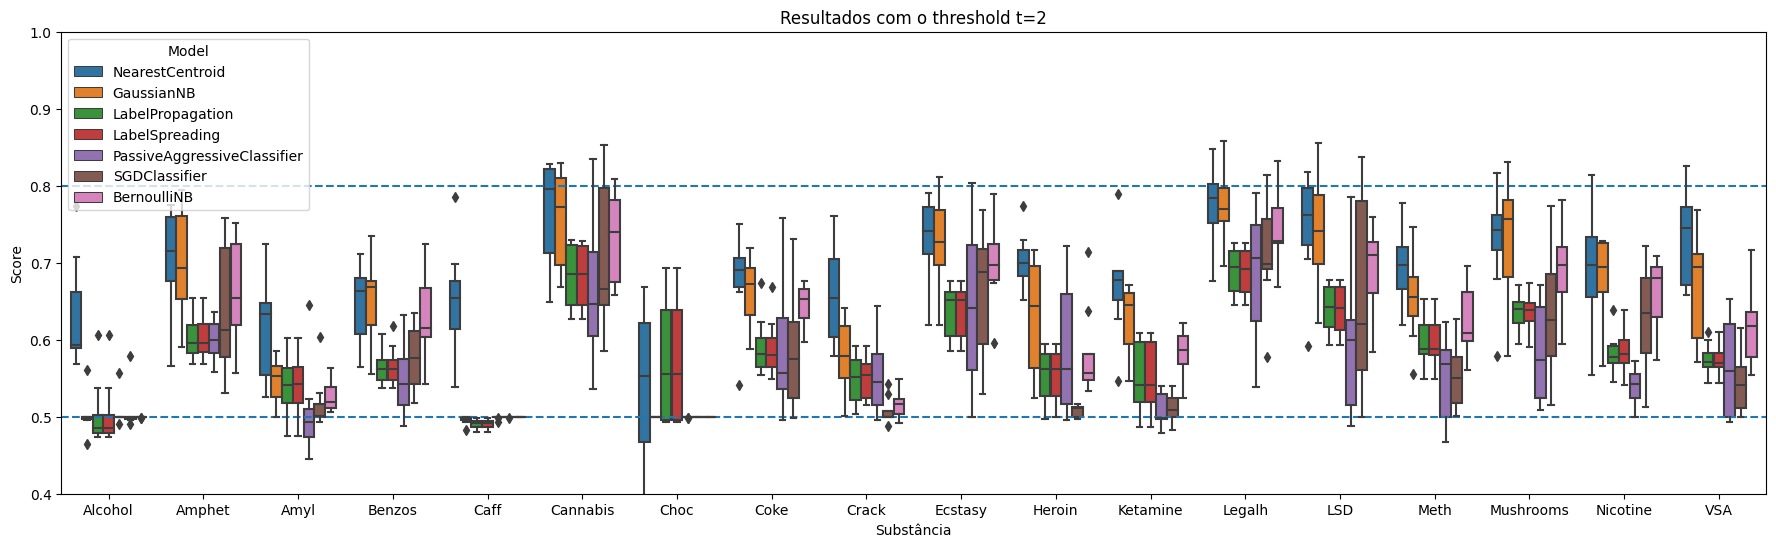

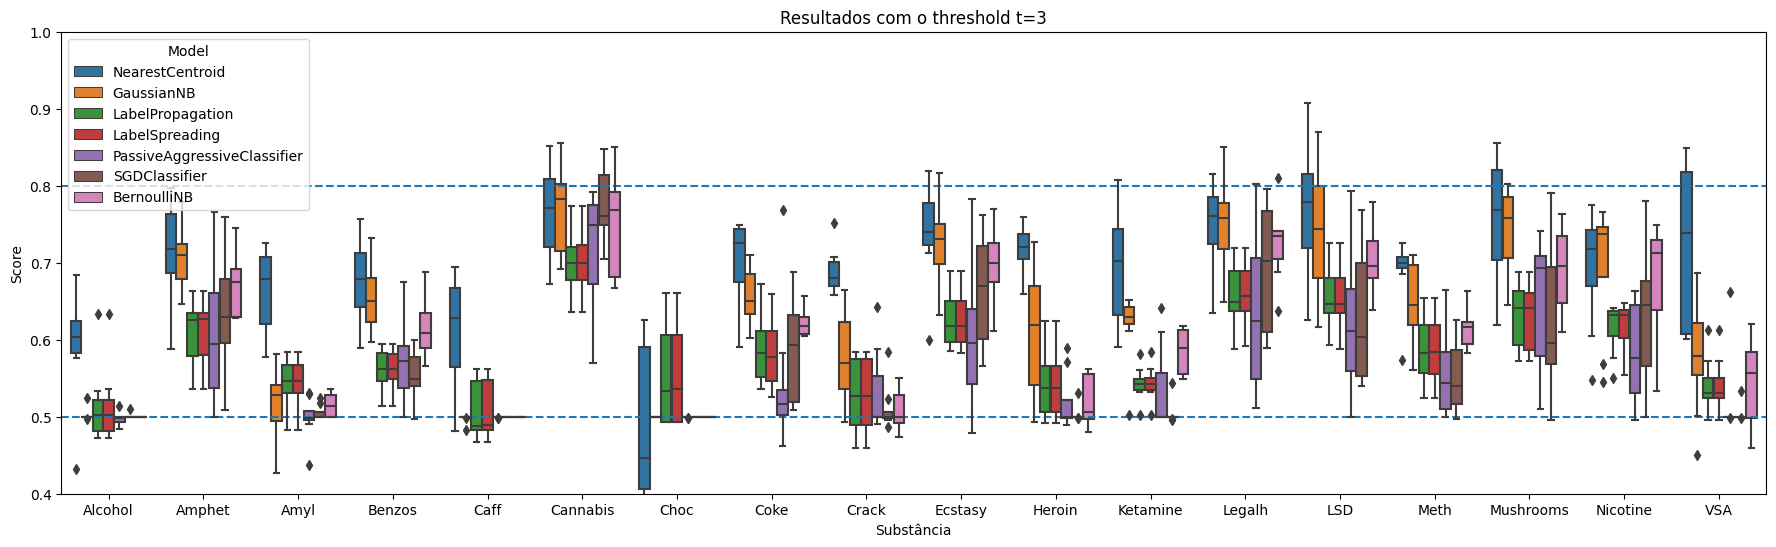

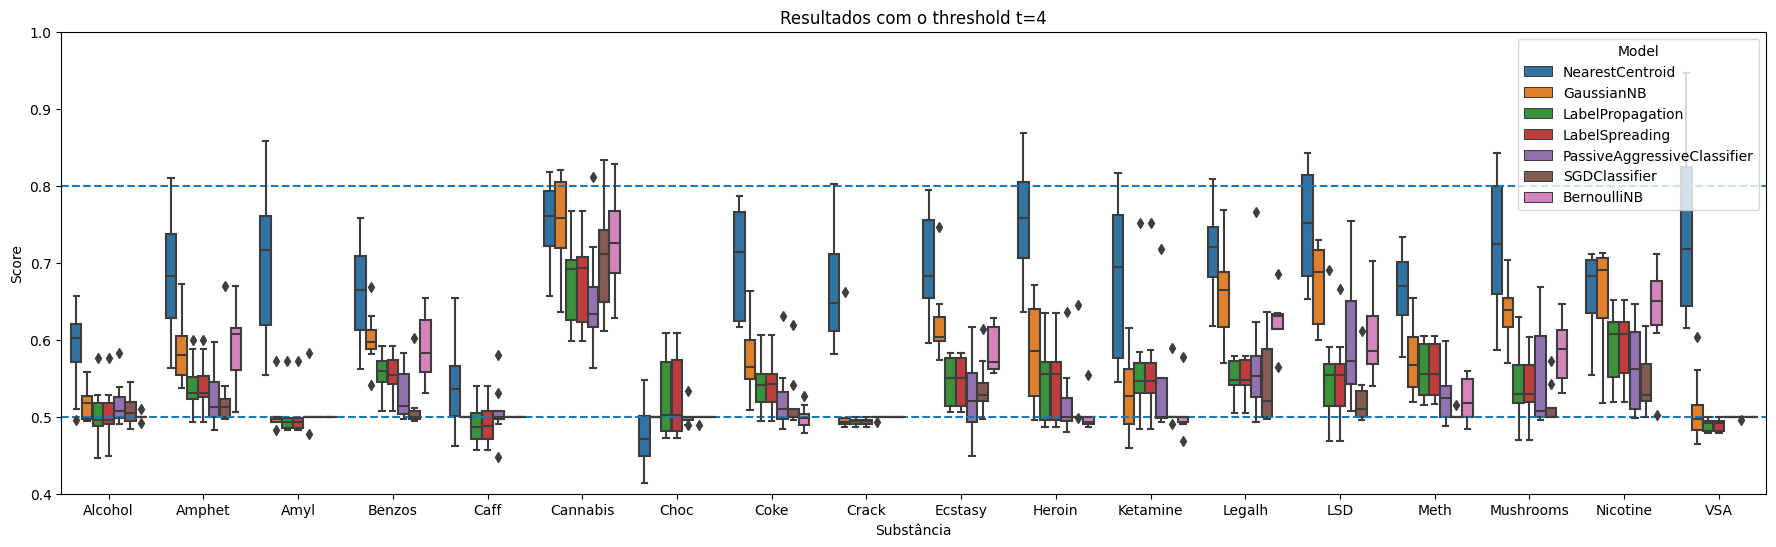

In [29]:
for t in [2, 3, 4]:
    X = data_filtered.drop(columns=ut.drugs + ignore_cols)
    labels = data_filtered[ut.drugs].applymap(ut.threshold, t=[t])

    results, _ = ut.test_classifiers(X, labels)

    ut.boxplot(results, f"Resultados com o threshold t={t}")
    display(ut.show_statistics(results))

Algumas observações:
- Substâncias lícitas mais comuns, como chocolate, álcool e cafeína, não possuem padrões bem definidos para realizar uma classificação, já que são gerais para a população (e talvez não há dados o suficiente para determinar isso);
- Entre os classificadores (sem busca de hiperparâmetros), o NearestCentroid teve melhor desempenho e, nele, são razoáveis os resultados de substâncias como Cannabis, cocaína, ecstasy, heroína, "legal highs" e LSD, principalmente.